# 5 Analysis Example

Now that we prepared the augmented dataset and ran `statmorph` on every image, we can analyze the output for a given parameter. The prcedure is as follows:

1. Select a subsample with *good* morphology measurements for the given metric (not NaN, positive, etc. - this depends on the metric).
2. Choose a tentative baseline - this is $\mathcal{R} = 100$ pc, $\mu_0 = 23.5$ mag/arcsec$^2$ in our work
3. Run `mutual_info_regression` to select two parameters between $(\mathcal{R}, \mathcal{R}_{\rm{eff}})$ and (SNR/px, $\mu_0$) that better predict the observed parameter from the baseline
4. Assign a new baseline for the sample
5. Make a bias grid
6. Make an example plot for two galaxies sampling different ends of the baseline value distribution
7. Save the tentative dataset and run Julia symbolic regression, where applicable
8. Make a plot showing the Julia correction, where applicable

#### Imports

In [79]:
import os 
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", SyntaxWarning)

from lib.analysis import get_baseline, get_important_features, plot_bias_grid, plot_example, prep_julia_analysis, load_sr_results, julia_str_to_func, symbolic_correction, plot_correction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.size'] = 11

## 1. Load the data

Load the overall morphology data, choose the parameter we want to study, and clean the catalog

In [3]:
morph = pd.read_csv('../data/catalogs/morph.csv')#.drop_duplicates(subset=['galaxy','pxscale_pc','sblim'], keep='last')
morph2 = pd.read_csv('../data/catalogs/morph2.csv')
morph3 = pd.read_csv('../data/catalogs/morph3.csv')
data = pd.concat([morph, morph2, morph3], ignore_index=True).drop_duplicates(subset=['galaxy','pxscale_pc','sblim'], keep='last')

Take logs of the resolution and SNR columns:

In [4]:
data['log_scale'] = np.log10(data.pxscale_pc)
data['log_snr'] = np.log10(data.sn_per_pixel) # change this later

Choose the parameter:

In [5]:
param = 'gini'
paramlabel = 'G'

Make directories to store output plots:

In [6]:
os.makedirs(f'../figures/{param}', exist_ok=True)

Here you can define quality cuts on your data/parameter or clean up the data in some way. 
> Plotting the distribution of parameter values can help!

Text(0, 0.5, 'G')

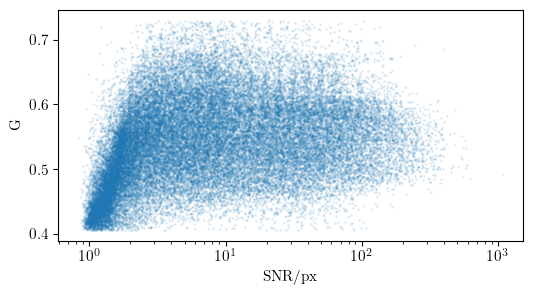

In [7]:
qs = data[param].quantile(q=[0.01, 0.99])
data = data[(data[param]>qs[0.01]) & (data[param] < qs[0.99]) & (data.sn_per_pixel > 0)]

plt.figure(figsize=(6,3))
plt.scatter(data.sn_per_pixel, data[param], s=1, alpha=0.1)
plt.xscale('log'); plt.xlabel('SNR/px'); plt.ylabel(paramlabel)

## 2. Assign the baseline 

For every galaxy, choose one row to be the baseline - this is the row closest to our baseline of 100 pc and 23.5 mag/arcsec$^2$.

In [8]:
base_sblim = 23.5
base_res = 100

Find the baseline row for every galaxy in the catalog:

In [9]:
data, no_matches = get_baseline(data, 'pxscale_pc', base_res, 'sblim', base_sblim, param)

No matching SB rows found for ic4255.
No matching SB rows found for ic4289.
No matching SB rows found for ic4374.
No matching SB rows found for ngc5258.


## 3. Important parameters

Here we run sklearn's [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) to find which parameter pairs -- between (physical resolution, effective resolution) and (SB limit, avg signal to noise) are better predictors of the parameter given the baseline value. We also add a random number to the regression as a reference point with no predictive power.

Best SNR column: log_snr		Baseline: 1.005
Best resolution column: log_nres	Baseline: 1.616


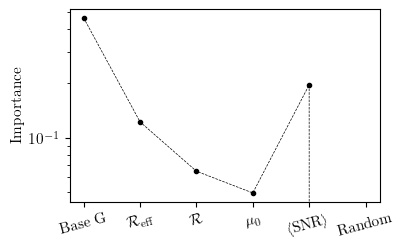

In [10]:
snr_col, base_snr, res_col, base_res, fig = get_important_features(data, param, paramlabel)
print(f'Best SNR column: {snr_col}\t\tBaseline: {base_snr:0.3f}')
print(f'Best resolution column: {res_col}\tBaseline: {base_res:0.3f}')
fig.savefig(f'../figures/{param}/importance.png', bbox_inches='tight', pad_inches=0)

Re-calculate the new baseline with our chosen values:

In [11]:
data, no_match2 = get_baseline(data, res_col, base_res, snr_col, base_snr, param)

No matching SNR rows found for coma123042.


How many galaxies are we left with?

In [12]:
print(f'Number of unique galaxies left: {len(data.galaxy.unique())}')

Number of unique galaxies left: 155


## 4. Bias and scatter grid

Now that we have generated the new baseline values, we can reproduce the plots from the paper, showing the average bias and scatter at varying levels of resolution and noise.

Define how do we actually want to calculate bias! Options are:
1. Error $y - y_{\rm{base}}$ (most parameters)
2. Fractional error $y/y_{\rm{base}}$ (useful for radii)
3. Absolute offset as a function of radius (only centroids)

In [13]:
data['err'] = data[f'd_{param}']

Make the plot:

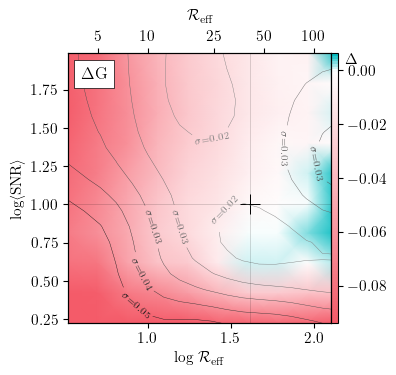

In [55]:
fig = plot_bias_grid(data, paramlabel, snr_col, base_snr, res_col, base_res)
plt.savefig(f'../figures/{param}/{param}_grid.png', bbox_inches='tight')

## 5. Example plot of two galaxies

To demonstrate the behaviour better, we choose two galaxies that have relatively high and low values of the chosen parameter, and plot the value of the parameter as a function of resolution for a deep and a shallow image.

Optionally, you can pick your own galaxies here.

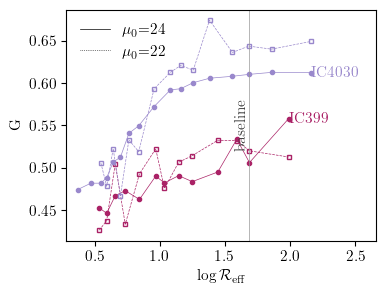

In [54]:
sblim_low = 22
sblim_high = 24
galaxy_low = None # Pick one at random
galaxy_high = None 

fig = plot_example(data, param, paramlabel, sblim_low, sblim_high, galaxy_low, galaxy_high)
fig.savefig(f'../figures/{param}/{param}_example.png',bbox_inches='tight')

## 6. Symbolic Regression correction in Julia

#### Save data
First, we save our dataset for training - we add some Gaussian noise to the dataframe values so that the fitting is better-behaved. 

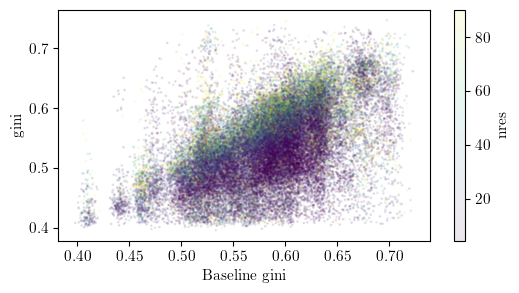

In [53]:
fig = prep_julia_analysis(data, param, res_col, snr_col, f'../data/catalogs/julia/{param}.csv')
fig.savefig(f'../figures/{param}/{param}_julia_dset.png',bbox_inches='tight')

#### Run Julia

This is done as a separate command outside of the notebook! The syntax is 

    julia regression.jl --param [parameter_name] --inpath [path to julia catalog] --outpath [path to save output]

Once it is done running (this will take a few hours), move the final fit result to `julia_cat_path` and return here to look at the regression results.

In [60]:
julia_cat_path = f'../data/catalogs/julia_output/{param}.csv'
julia_cat = load_sr_results(julia_cat_path)
julia_cat

,Complexity,Loss,Equation,Score,best
0,2,0.045488,f = 0.7732476633164367; g = 0.09751393289355131,0.000000,False
1,3,0.044215,f = 0.9297048563779262; g = 0.0002393480918657...,1.232287,False
2,4,0.039547,f = 0.8239433605462421; g = log10(#1) * 0.0527...,4.846025,True
3,5,0.038106,f = 0.8059217980058936; g = tanh(0.07251634957...,1.611515,False
4,6,0.034833,f = 0.8113288925601879; g = tanh(#2) * (log10(...,3.899934,False
5,7,0.034092,f = (-0.5916360333836804 * inv(#1)) + 0.831590...,0.933817,False
6,8,0.033110,f = inv(-2.252952507510173 - #1) + 0.845072868...,1.269770,False
7,9,0.032912,f = 0.815374816825641 + inv(-2.260873831061626...,0.260105,False
8,10,0.032759,f = 0.8441796925837499 + inv(inv(-0.1296821323...,0.202419,False
9,11,0.032545,f = inv(inv(#1 * -0.13296630852802047) - #1) +...,0.284502,False


#### Choose an equation and make a correction

We assign a score to each equation based on its loss and complexity: 

$$ \rm{Score}_i =  100 \times \frac{-\log \rm{Loss}_i / \rm{Loss}_{i-1}}{\rm{Complexity}_i - \rm{Complexity}_{i-1}}$$

By default, we chose the correction with the **lowest complexity and score $>$ 1**. 

This is somewhat arbitrary and more complex equations usually perform better, especially in low-SNR and/or poor-resolution regimes. It is best to go through these equations iteratively and choose the one that suits your science needs best - e.g., picking one that corrects SNR < 1 data points well.

In [90]:
corr_data = symbolic_correction(data, param, julia_res_col, julia_snr_col, julia_cat, row_idx=4)

Plot the correction:

In [91]:
#### Temporary
corr_data['snr_px'] = corr_data['sn_per_pixel']

In [ ]:
fig = plot_correction(corr_data, param, paramlabel, reslim=5, snrlim=2, xlims=None)
plt.savefig(f'../figures/{param}/{param}_corr.png', bbox_inches='tight')

## All done!